# A Fuzzy Model for Managing Natural Noise in Recommender Systems

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib notebook

from time import time
from numpy import save, load
from collections import defaultdict

from surprise import Reader
from surprise import Dataset
from surprise import accuracy
from surprise import KNNBaseline
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split

tic = time()
np.random.seed(1593523459)

### Datasets:
* MovieLens-100K
* MovieLens-1M

### Variables:
* ```PU``` - dictionary with user profiles [ userID, fuzzyTransformation( profiles ) ]
* ```PI``` - dictionary with item profiles [ itemID, fuzzyTransformation( profiles ) ]
* ```variable``` - profiles with [ 0, 0, 0 ]
* ```TRESHOLD``` - treshold for detecting noise rating

In [2]:
PU = defaultdict(list)
PI = defaultdict(list)
variable = np.array([0, 0, 0])

TRIGGER = 'M'

if TRIGGER == 'K':
    TRESHOLD_1 = 1
    TRESHOLD_2 = 1
    ml_name = 'ml-100k'
    data = load('../datasets/main/train_set_100K.npy')
#     data = np.loadtxt('../datasets/main/ml-100k.data', skiprows=0, delimiter='\t').astype('int32')

elif TRIGGER == 'M':
    TRESHOLD_1 = 1
    TRESHOLD_2 = 1.7
    ml_name = 'ml-1m'
    data = load('../datasets/main/train_set_1M.npy')
#     data = np.loadtxt('../datasets/main/ml-1M.dat', skiprows=0, delimiter='::').astype('int32')

In [3]:
data

array([[        1,         1,         5, 978824268],
       [        1,        48,         5, 978824351],
       [        1,       150,         5, 978301777],
       ...,
       [     6040,      3703,         4, 964828575],
       [     6040,      3751,         4, 964828782],
       [     6040,      3819,         5, 963272166]])

In [4]:
# Convert to DataFrame and filter the dataset by 'user' and 'item'
data_csv = pd.DataFrame(data, columns = ['user', 'item', 'rating', 'timestamp'])
data_csv.sort_values(['user', 'item'], ascending=[True, True], inplace=True)
data_csv.reset_index(inplace=True)
data_csv.drop('index', axis=1, inplace=True)
data_csv

,user,item,rating,timestamp
0,1,1,5,978824268
1,1,48,5,978824351
2,1,150,5,978301777
3,1,260,4,978300760
4,1,527,5,978824195
...,...,...,...,...
900184,6040,3671,4,997454367
900185,6040,3683,4,960971696
900186,6040,3703,4,964828575
900187,6040,3751,4,964828782


In [5]:
users = np.unique(data[:, 0]).tolist() # list of unique users
items = np.unique(data[:, 1]).tolist() # list of unique items

In [6]:
n_u = len(users)     # number of users
n_m = len(items)     # number of movies
n_r = data.shape[0]  # number of ratings

print("USERS: {}\t ITEMS: {}\t RATINGS: {}".format(n_u, n_m, n_r))

USERS: 6040	 ITEMS: 3694	 RATINGS: 900189


In [7]:
# Make dict for users and movies, where udict[u_id] = index(0..942), and mdict[m_id] = index(0..1681)
udict = {}
for i, u_id in enumerate(users):
    udict[u_id] = i
    
mdict = {}
for i, m_id in enumerate(items):
    mdict[m_id] = i

In [8]:
# Empty matrix
matrix = np.zeros((n_u, n_m), dtype='int32')

In [9]:
# Fill matrix
for i in range(n_r):
    u_id = data[i, 0]
    m_id = data[i, 1]
    r = data[i, 2]
    
    matrix[udict[u_id], mdict[m_id]] = int(r)

In [10]:
matrix

array([[5, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [3, 0, 0, ..., 0, 0, 0]])

#### Train Algorithm

In [11]:
# Load the movielens-100k-1m dataset
dataset_1 = Dataset.load_builtin(ml_name) # 'ml-100k' and 'ml-1m'

# Retrieve the trainset.
trainset, testset = train_test_split(dataset_1, test_size=.1)

# Build an algorithm, and train it.
knn = KNNBaseline(k=60)

# Fit data
knn.fit(trainset)

# Test
knn_predictions = knn.test(testset)

# Then compute RMSE
accuracy.rmse(knn_predictions)

# get a prediction for specific users and items.
knn_pred = knn.predict(str(196), str(302), r_ui=4, verbose=True)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.8926
user: 196        item: 302        r_ui = 4.00   est = 3.84   {'actual_k': 60, 'was_impossible': False}


In [12]:
def predict_rating(u_id, i_id): 
    rating = round(knn.predict(str(u_id), str(i_id))[3], 3)
    
    return rating

In [13]:
def fuzzy_transformation(r):
    if 1 <= r <= 1.5:
        low = 1
    elif 1.5 < r <= 2:
        low = -2*r + 4
    elif 2 < r <= 5:
        low = 0
        
    if 1 <= r <= 1.5:
        med = 0
    elif 1.5 < r <= 2:
        med = 2*r - 3
    elif 2 < r <= 3:
        med = 1
    elif 3 < r <= 4:
        med = -r + 4
    elif 4 < r <= 5:
        med = 0
        
    if 1 <= r <= 3:
        high = 0
    elif 3 < r <= 4:
        high = r - 3
    elif 4 < r <= 5:
        high = 1

    return np.array([low, med, high])

In [14]:
def f1(array):
    updated = []
    
    for x in array:
        if 0 <= x <= 0.35:
            updated.append(0)
        elif 0.35 < x <= 1:
            updated.append(20/13*x - 7/13)
    
    return np.array(updated)

In [15]:
def dist(a, b):
    return sum(abs(a - b))

In [16]:
def skip_unsuitable_profiles(pu, pi):
    if (pu == variable).all() or (pi == variable).all() or (dist(pu, pi) > TRESHOLD_1):
        return True

In [17]:
def skip_unnoisy_ratings(pu, pi, r):
    if min( dist(pu, fuzzy_transformation(r)), dist(pi, fuzzy_transformation(r)) ) < TRESHOLD_2:
        return True

In [18]:
def dissimilarity(p, r):
    return dist(p, r) - 1

In [19]:
def get_noise_degree(pu, pi, r):
    return min(dissimilarity(pu, fuzzy_transformation(r)), dissimilarity(pi, fuzzy_transformation(r)))

In [20]:
def get_profiles(users, items):
    # User Profile
    for u_id in users:  
        count = 0
        ft = np.array([0, 0, 0])

        for i_id in items:
            r = matrix[udict[u_id], mdict[i_id]]
            if r == 0: continue
            count += 1
            ft += fuzzy_transformation(r)
            
        PU[u_id] = f1(ft / count) 
            
    # Item Profile    
    for i_id in items:
        count = 0
        ft = np.array([0, 0, 0])
        
        for u_id in users:
            r = matrix[udict[u_id], mdict[i_id]]
            if r == 0: continue
            count += 1
            ft += fuzzy_transformation(r)
        
        PI[i_id] = f1(ft / count)
        
    return PU, PI

In [21]:
def noise_correction(matrix, PU, PI):
    final_matrix = matrix.copy().astype('float32')
    count_time = 0
    
    for u_id in users:
        for i_id in items:
            r = matrix[udict[u_id], mdict[i_id]]
            if r == 0: continue
            if skip_unsuitable_profiles(PU[u_id], PI[i_id]): continue
            if skip_unnoisy_ratings(PU[u_id], PI[i_id], r): continue
            
            n = predict_rating(u_id, i_id)
            noise_degree = get_noise_degree(PU[u_id], PI[i_id], r)
            newRating = r * (1 - noise_degree) + n * noise_degree
            
            count_time += 1
            if count_time % 100 == 0:
                print('{0}\t{1}\t{2:0.3f}\t{3:0.3f}\t{4:0.3f}'.format(count_time, r, n, noise_degree, newRating) )
            
            final_matrix[udict[u_id], mdict[i_id]] = newRating
            
    print('\nTotal:', count_time)
    
    return final_matrix

In [22]:
def reshape_data(final_matrix):
    data_sorted = np.array(data_csv)                                             # get sorted data
    new_ratings = final_matrix.reshape(-1, 1)                                    # reshape into one column
    new_ratings = new_ratings[new_ratings != 0].reshape(-1, 1).astype('float32') # remove empty ratings

    new_data = np.hstack((data_sorted[:,:2], new_ratings))                       # combine
    
    return new_data

# Running

In [23]:
# Get matrix with degree of noises
PU, PI = get_profiles(users, items)

In [25]:
# Correct the Matrix
final_matrix = noise_correction(matrix, PU, PI)

100	3	3.498	0.661	3.329
200	3	4.145	0.652	3.746
300	3	3.299	0.596	3.178
400	3	3.583	0.597	3.348
500	3	3.605	0.608	3.368
600	3	4.185	0.615	3.728
700	2	3.734	0.507	2.878
800	1	3.874	0.681	2.957
900	3	3.668	0.529	3.353
1000	3	3.838	0.650	3.545
1100	3	4.066	0.509	3.543
1200	1	3.650	0.634	2.681
1300	3	3.386	0.529	3.204
1400	3	3.241	0.527	3.127
1500	3	3.231	0.600	3.139
1600	3	3.923	0.526	3.485
1700	3	3.470	0.580	3.273
1800	3	3.683	0.822	3.562
1900	3	3.383	0.511	3.196
2000	1	4.289	0.521	2.713
2100	2	4.437	0.580	3.414
2200	3	3.280	0.590	3.165
2300	3	4.032	0.554	3.572
2400	3	3.458	0.579	3.265
2500	2	3.686	0.615	3.038
2600	3	4.153	0.607	3.700
2700	3	3.667	0.591	3.394
2800	4	2.438	0.527	3.177
2900	2	4.092	0.586	3.225
3000	1	3.495	0.504	2.258
3100	3	3.965	0.516	3.498
3200	2	3.382	0.667	2.922
3300	3	4.461	0.629	3.920
3400	3	4.015	0.501	3.509
3500	3	3.815	0.634	3.516
3600	3	3.683	0.504	3.344
3700	3	4.081	0.742	3.802
3800	3	3.722	0.578	3.417
3900	2	3.579	0.633	2.999
4000	2	3.908	0.539	3.029
4100	3	3.

In [26]:
new_data = reshape_data(final_matrix)

In [27]:
# # Save final matrix

# if TRIGGER == 'K':
#     file_matrix = '../datasets/filter_4/final_matrix_100K_{0}.npy'.format(TRESHOLD_2)
#     file_new_data = '../datasets/filter_4/dataset_100K_{0}.npy'.format(TRESHOLD_2)
    
#     save(file_new_data, new_data)
#     save(file_matrix, final_matrix)

#     new_data_load = load(file_new_data)
    
# elif TRIGGER == 'M':
#     file_matrix = '../datasets/filter_4/final_matrix_1M_{0}.npy'.format(TRESHOLD_2)
#     file_new_data = '../datasets/filter_4/dataset_1M_{0}.npy'.format(TRESHOLD_2)
    
#     save(file_new_data, new_data)
#     save(file_matrix, final_matrix)

#     new_data_load = load(file_new_data)

### Results

In [28]:
# (new_data == new_data_load).all()

In [29]:
new_data_load = new_data
new_data_csv = pd.DataFrame(new_data_load, columns = ['user', 'item', 'rating'])
new_data_csv

,user,item,rating
0,1.0,1.0,5.0
1,1.0,48.0,5.0
2,1.0,150.0,5.0
3,1.0,260.0,4.0
4,1.0,527.0,5.0
...,...,...,...
900184,6040.0,3671.0,4.0
900185,6040.0,3683.0,4.0
900186,6040.0,3703.0,4.0
900187,6040.0,3751.0,4.0


In [30]:
print('Preprocessing time: {0} mins!'.format( int( (time() - tic) / 60.0 ) ) )

Preprocessing time: 4 mins!


### Visualization

In [31]:
new_data_csv['updated'] = new_data_csv['rating'].round(1)
new_data_csv

,user,item,rating,updated
0,1.0,1.0,5.0,5.0
1,1.0,48.0,5.0,5.0
2,1.0,150.0,5.0,5.0
3,1.0,260.0,4.0,4.0
4,1.0,527.0,5.0,5.0
...,...,...,...,...
900184,6040.0,3671.0,4.0,4.0
900185,6040.0,3683.0,4.0,4.0
900186,6040.0,3703.0,4.0,4.0
900187,6040.0,3751.0,4.0,4.0


In [32]:
data_csv['rating'].value_counts().sort_index(ascending=False)

5    203635
4    314124
3    235097
2     96696
1     50637
Name: rating, dtype: int64

In [33]:
new_data_csv['updated'].value_counts().sort_index(ascending=False)

5.0    203633
4.6         2
4.5         7
4.4        11
4.3        29
4.2        56
4.1       124
4.0    314379
3.9       472
3.8       853
3.7      1463
3.6      2298
3.5      2531
3.4      2245
3.3      1581
3.2       884
3.1       488
3.0    222782
2.9       324
2.8       278
2.7       292
2.6       225
2.5       201
2.4       175
2.3       147
2.2       100
2.1        76
2.0     94596
1.9        43
1.8        26
1.7        30
1.6        18
1.5        17
1.4        20
1.3         8
1.2         3
1.0     49772
Name: updated, dtype: int64

<IPython.core.display.Javascript object>


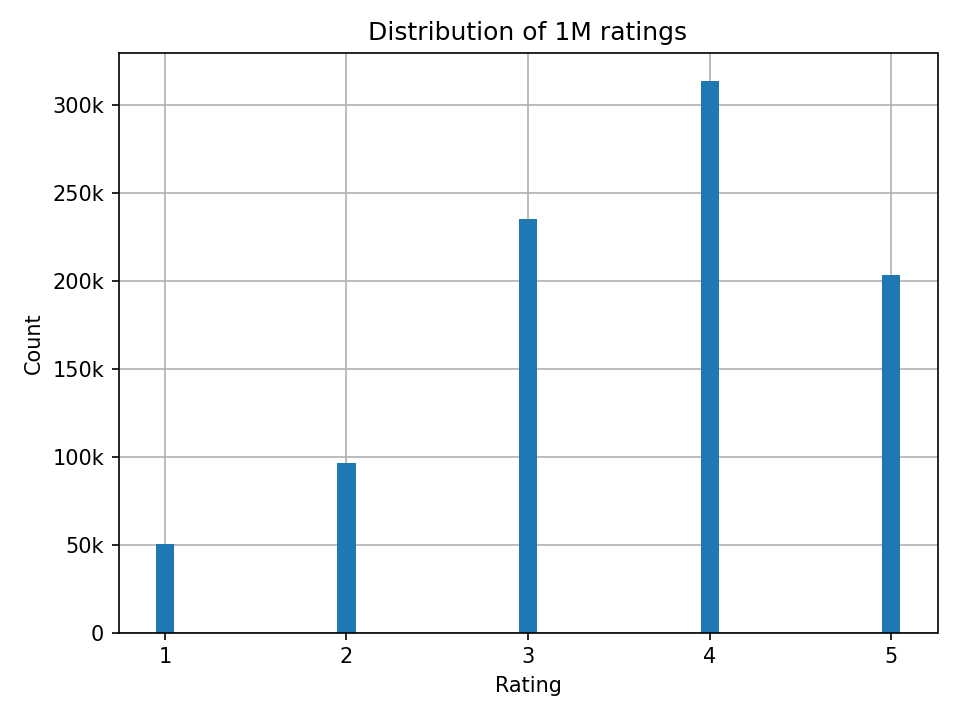

In [34]:
# Create a Figure with Axes
fig1, ax = plt.subplots()

# Coordinates 
data_rating = data_csv['rating'].value_counts().sort_index(ascending=False)

x1 = data_rating.index
y1 = data_rating.values

# Draw the bars and add the text
ax.bar(x1, y1, width=0.1, zorder=2)

# Update the yticks
locs, labels = plt.yticks()
locs_updated = ['%dk'%(round(v/1000)) if v!=0 else '0' for v in locs]
plt.yticks(ticks=locs[:-1], labels=locs_updated[:-1])

# Title and X, Y Labels
ax.set_xlabel('Rating')
ax.set_ylabel('Count')
ax.set_title('Distribution of 1M ratings')

# Some additional functions
ax.grid(zorder=0)
fig1.tight_layout()

# Save and show figure
# fig1.savefig('./datasets/images/1. ratings bar.pdf')
fig1.show()

<IPython.core.display.Javascript object>


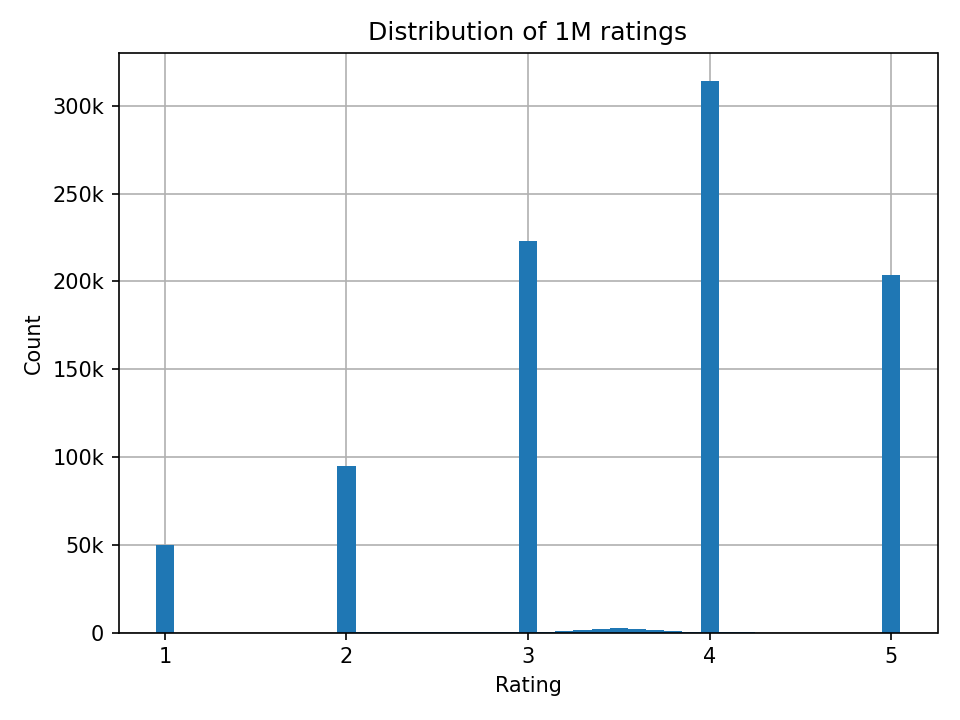

In [35]:
# Create a Figure with Axes
fig2, ax = plt.subplots()

# Coordinates 
new_data_rating = new_data_csv['updated'].value_counts().sort_index(ascending=False)

x2 = new_data_rating.index
y2 = new_data_rating.values

# Draw the bars and add the text
ax.bar(x2, y2, width=0.1, zorder=2)

# Update the yticks
locs, labels = plt.yticks()
locs_updated = ['%dk'%(round(v/1000)) if v!=0 else '0' for v in locs]
plt.yticks(ticks=locs[:-1], labels=locs_updated[:-1])

# Title and X, Y Labels
ax.set_xlabel('Rating')
ax.set_ylabel('Count')
ax.set_title('Distribution of 1M ratings')

# Some additional functions
ax.grid(zorder=0)
fig2.tight_layout()

# Save and show figure
# fig1.savefig('./datasets/images/1. ratings bar.pdf')
fig2.show()

# Evaluate accuracy

In [36]:
TRESHOLD_2

1.5

In [37]:
# # new_data_load = load('../datasets/filter_4/dataset_100K_{0}.npy'.format(TRESHOLD_2))
# new_data_load = load('../datasets/filter_4/dataset_1M_{0}.npy'.format(TRESHOLD_2))
# new_data_csv = pd.DataFrame(new_data_load, columns = ['user', 'item', 'rating'])
# new_data_csv

In [38]:
# # A reader is still needed but only the rating_scale param is requiered.
# reader = Reader(rating_scale=(1, 5))

# # The columns must correspond to user id, item id and ratings (in that order).
# dataset_2 = Dataset.load_from_df(new_data_csv[['user', 'item', 'rating']], reader)

# # Build an algorithm, and train it.
# knn_2 = KNNBaseline(k=60)

# # Run 5-fold cross-validation and print results.
# cross_validate(knn_2, dataset_2, measures=['RMSE', 'MAE'], cv=5, verbose=True)

In [39]:
# A reader is still needed but only the rating_scale param is requiered.
reader = Reader(rating_scale=(1, 5))

# The columns must correspond to user id, item id and ratings (in that order).
dataset_2 = Dataset.load_from_df(new_data_csv[['user', 'item', 'rating']], reader)

# Retrieve the trainset.
trainset, testset = train_test_split(dataset_2, test_size=.1)

# Build an algorithm, and train it.
knn_2 = KNNBaseline(k=60)

# Fit data
knn_2.fit(trainset)

# Test
knn_predictions = knn_2.test(testset)

# Then compute RMSE
accuracy.rmse(knn_predictions)

# get a prediction for specific users and items.
knn_pred = knn_2.predict(str(196), str(302), r_ui=4, verbose=True)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.8699
user: 196        item: 302        r_ui = 4.00   est = 3.59   {'was_impossible': False}


In [40]:
# RMSE: 0.8841     TRESHOLD = 1.7
# RMSE: 0.8699     TRESHOLD = 1.5

In [41]:
# RMSE: 0.8926     Base                    1.5 <= TRESHOLD <= 1.8          Base
# RMSE: 0.8053     TRESHOLD = 1
# RMSE: 0.8731     TRESHOLD = 1.5

# RMSE: 0.8856     TRESHOLD = 1.6

# RMSE: 0.8874     TRESHOLD = 1.7
# RMSE: 0.8917     TRESHOLD = 1.8

In [42]:
# RMSE: 0.8926     Base                    1.5 <= TRESHOLD <= 1.8          Train_data
# RMSE: 0.8061     TRESHOLD = 1
# RMSE: 0.8786     TRESHOLD = 1.5

# RMSE: 0.8896     TRESHOLD = 1.6
# RMSE: 0.8942     TRESHOLD = 1.7

# RMSE: 0.8949     TRESHOLD = 1.8